# Classificacao-SPAM

### Lorenzo Carneiro Magalhães

##### A abordagem para a solução do problema foi realizada utilizando processamento de linguagem natural e redes neurais.

Passos:
1. Pré-processamento dos dados no pandas
2. Processamento das frases, de maneira a remover caracteres não alfabéticos
3. Transformar as frases em dados numéricos através do CountVectorizer do sklearn
4. Criação do modelo e separação dos dados em dados de treino e teste
5. Treino do modelo


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
seed_random=42
torch.manual_seed(seed_random)

In [7]:
data = pd.read_csv('botClassificator.csv', encoding = "ISO-8859-1", usecols=[0,1,2], names=["tweet", "id", "label"])
data.head()

,tweet,id,label
0,tweet,id,label
1,Daniel Torres P,Ecuador,0
2,RT @nishy03: G7ãã¸ã¿ã«ã»æè¡å¤§è£ä¼å...,1422375334612062209,0
3,ã¡ããwowakaãã ãããã kemuããã...,1437286635779936261,0
4,@May_lcp ChatGPT te salvarÃ¡,498531048,0


In [8]:
data.dropna(inplace=True)
change_labels = lambda x: 1 if x=='spam' else 0
data['label'] = data['label'].apply(change_labels)
data.head()

,tweet,id,label
0,tweet,id,0
1,Daniel Torres P,Ecuador,0
2,RT @nishy03: G7ãã¸ã¿ã«ã»æè¡å¤§è£ä¼å...,1422375334612062209,0
3,ã¡ããwowakaãã ãããã kemuããã...,1437286635779936261,0
4,@May_lcp ChatGPT te salvarÃ¡,498531048,0


In [9]:
remove_non_alphabets = lambda x: re.sub(r'[^a-zA-Z]',' ',x)

In [10]:
tokenize = lambda x: word_tokenize(x)

In [12]:
data['tweet'] = data['tweet'].apply(remove_non_alphabets)
data['tweet'] = data['tweet'].apply(tokenize)
data['tweet'] = data['tweet'].apply(lambda x: ' '.join(x))
data.head()

,tweet,id,label
0,tweet,id,0
1,Daniel Torres P,Ecuador,0
2,RT nishy G ChatGPT https t co BzcId L,1422375334612062209,0
3,wowaka kemu P ChatGPT MIX P https t co uKBJfmpIs,1437286635779936261,0
4,May lcp ChatGPT te salvar,498531048,0


Foi utilizado um número máximo de palavras, a fim de tornar o modelo mais simples (não utilizar encoder/decoder)

In [13]:
max_words = 5000 # 7411 máximo
cv = CountVectorizer(max_features=max_words, stop_words='english')
sparse_matrix = cv.fit_transform(data['tweet']).toarray()

In [14]:
sparse_matrix.shape

(2422, 5000)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(sparse_matrix, np.array(data['label']), random_state=seed_random)

In [16]:
class LogisticRegression(nn.Module):
    def __init__(self, max_words):
        super().__init__()
        self.linear1 = nn.Linear(max_words, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [17]:
model = LogisticRegression(max_words=max_words)

In [18]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters() , lr=0.01)

In [19]:
x_train = torch.from_numpy(x_train).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.float)

Observar o padrão dos dados

In [20]:
x_train[0], y_train[0]

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor(0.))

In [21]:
model(x_train[0])

tensor([-0.2977], grad_fn=<AddBackward0>)

#### Loop de treino

In [22]:
epochs = 20
model.train()
loss_values = []
for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    y_pred = model(x_train).squeeze()
    loss = loss_fn(y_pred, y_train)

    loss_values.append(loss.item())
    if epoch % 5 == 0:
        pred = torch.round(torch.sigmoid(y_pred)).eq(y_train).sum()
        acc = pred * 100.0 / len(x_train)
        print('Epoch: {}, Loss: {}, Accuracy: {}%'.format(epoch+1, loss.item(), acc.numpy()))
    
    loss.backward()
    optimizer.step()

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.5542523264884949, Accuracy: 100.0%


 50%|█████     | 10/20 [00:00<00:00, 19.38it/s]

Epoch: 6, Loss: 0.2553064823150635, Accuracy: 100.0%
Epoch: 11, Loss: 0.04154709354043007, Accuracy: 100.0%


100%|██████████| 20/20 [00:00<00:00, 20.57it/s]

Epoch: 16, Loss: 0.0033003140706568956, Accuracy: 100.0%


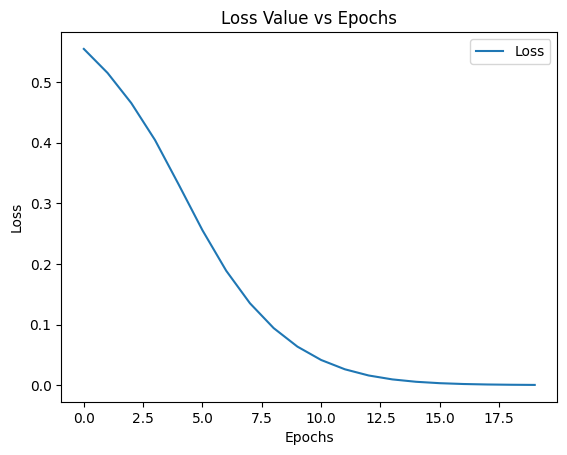

In [23]:
plt.plot(loss_values)
plt.title('Loss Value vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])
plt.show()

In [24]:
x_test = torch.from_numpy(x_test).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.float)

### Resultados

In [26]:
model.eval()
with torch.no_grad():
    y_pred = model(x_test).squeeze()
    loss = loss_fn(y_pred, y_test)
    pred = torch.round(torch.sigmoid(y_pred)).eq(y_test).sum()
    print ("Accuracy : {}%".format(100*pred/len(x_test)))

Accuracy : 100.0%


#### A acurácia do modelo é de 98.56%, o que resulta em aproximadamente 4 pontos percentuais de melhoria, o que leva a crer que esse modelo é melhor